In [54]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import seaborn as sns
sns.set()

In [55]:
df = pd.read_csv('USAID_Anticorruption_Projects_Database.csv')

In [56]:
df.head()

,uuid,region,country,proj_nm,st_date,end_date,awd_amount,awd_value,implementer,sector,...,rfp_rftop,final_res,mind_eval,final_eval,audit,interim_rep,addl_docs,addl_info,corruption,stability
0,1,South and Central Asia (SCA),Afghanistan,Assistance for Afghanistan's Anti-Corruption A...,2010,2013,e) $25 M-$50 M,26642989,Management Systems International (MSI),"Independent Agencies, Civil Society",...,NaN,http://pdf.usaid.gov/pdf_docs/PA00JP3T.pdf,NaN,NaN,NaN,NaN,http://www.msiworldwide.com/project/supporting...,NaN,High Corruption,Unstable
1,2,South and Central Asia (SCA),Afghanistan,Rule of Law Stabilization Program - Formal Com...,2010,2012,e) $25 M-$50 M,33700000,TetraTech ARD,Rule of Law,...,NaN,NaN,NaN,http://pdf.usaid.gov/pdf_docs/PDACU496.pdf,NaN,NaN,NaN,NaN,Very High Corruption,Very Unstable
2,3,South and Central Asia (SCA),Afghanistan,Afghanistan Rule of Law Stabilization Project ...,2011,2012,c) $5 M-$10 M,10000000,"Checchi and Company Consulting, Inc.",Rule of Law,...,NaN,http://pdf.usaid.gov/pdf_docs/PDACY340.pdf,NaN,http://pdf.usaid.gov/pdf_docs/PDACW029.pdf,NaN,NaN,http://www.checchiconsulting.com/index.php?opt...,NaN,Very High Corruption,Very Unstable
3,4,South and Central Asia (SCA),Afghanistan,Political Party Assessment,2012,2012,a) <$1 M,NaN,"Checchi and Company Consulting, Inc.",Elections and Political Processes,...,NaN,http://pdf.usaid.gov/pdf_docs/PNADZ833.pdf,NaN,NaN,NaN,NaN,NaN,NaN,Very High Corruption,Very Unstable
4,30,Europe and Eurasia (E&E),Albania,Justice Sector Strengthening Project (JuST),2010,2015,c) $5 M-$10 M,9012613,Chemonics,"Rule of Law, Civil Society",...,https://www.fbo.gov/index?s=opportunity&mode=f...,NaN,NaN,NaN,NaN,http://pdf.usaid.gov/pdf_docs/PA00HWM1.pdf,NaN,NaN,High Corruption,Unstable


## Data pre-processing for textual variables

### 1. Lowercasing

In [57]:
df['proj_res'] = df['proj_res'].astype(str)

In [58]:
## Lowercase all descriptions
df['proj_res'] = df['proj_res'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### 2. Special characters

In [59]:
## remove punctuation
df['proj_res'] = df['proj_res'].str.replace('[^\w\s]','')

### 3. Stopwords

In [60]:
stop = stopwords.words('english')
df['proj_res'] = df['proj_res'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### 4. Stemming

"This will help us in text classification to deal with the curse of dimensionality but to calculate the sentiment score this process is not useful."

In [61]:
st = PorterStemmer()
df['proj_res'] = df['proj_res'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

## Sentiment Score

In [62]:
## Define a function which can be applied to calculate the score for the whole dataset
 
def senti(x):
    return TextBlob(x).sentiment

In [63]:
df['senti_score'] = df['proj_res'].apply(senti)

In [64]:
df.senti_score.head()

0                     (0.43, 0.5700000000000001)
1    (0.009090909090909094, 0.48863636363636365)
2                                     (0.0, 0.0)
3       (0.3888888888888889, 0.6388888888888888)
4     (0.11000000000000001, 0.33999999999999997)
Name: senti_score, dtype: object

"As it can be observed there are two scores: the first score is sentiment polarity which tells if the sentiment is positive or negative and the second score is subjectivity score to tell how subjective is the text". The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [65]:
df2 = df[['uuid','proj_res', 'senti_score']]

In [66]:
df2[['res_polarity', 'res_subjectivity']] = pd.DataFrame(df2['senti_score'].tolist()) #split senti_score to polarity and subjectivity

In [67]:
df2.head()

,uuid,proj_res,senti_score,res_polarity,res_subjectivity
0,1,program develop work relationship high offic o...,"(0.43, 0.5700000000000001)",0.430000,0.570000
1,2,project set legal educ train judg help modern ...,"(0.009090909090909094, 0.48863636363636365)",0.009091,0.488636
2,3,project reach 37583 particip phase 1 project a...,"(0.0, 0.0)",0.000000,0.000000
3,4,assess team found develop polit organ whether ...,"(0.3888888888888889, 0.6388888888888888)",0.388889,0.638889
4,30,septemb 30 2012 project instal digit record eq...,"(0.11000000000000001, 0.33999999999999997)",0.110000,0.340000


In [68]:
df3 = df2[['uuid', 'proj_res','res_polarity','res_subjectivity']]

In [69]:
df3.head()

,uuid,proj_res,res_polarity,res_subjectivity
0,1,program develop work relationship high offic o...,0.430000,0.570000
1,2,project set legal educ train judg help modern ...,0.009091,0.488636
2,3,project reach 37583 particip phase 1 project a...,0.000000,0.000000
3,4,assess team found develop polit organ whether ...,0.388889,0.638889
4,30,septemb 30 2012 project instal digit record eq...,0.110000,0.340000


In [70]:
def label_polarity (row):
   if row['res_polarity'] > 0 :
      return 'positive'
   elif row['res_polarity'] == 0:
      return 'neutral'
   else: 
      return 'negative'

In [71]:
def label_subj (row):
   if row['res_subjectivity'] > 0.5 :
      return 'subjective'
   else: 
      return 'objective'

In [72]:
df3['res_polarity_label'] = df3.apply(lambda row: label_polarity(row), axis=1)

In [73]:
df3['res_subjectivity_label'] = df3.apply (lambda row: label_subj(row), axis=1)

In [74]:
df3.head()

,uuid,proj_res,res_polarity,res_subjectivity,res_polarity_label,res_subjectivity_label
0,1,program develop work relationship high offic o...,0.430000,0.570000,positive,subjective
1,2,project set legal educ train judg help modern ...,0.009091,0.488636,positive,objective
2,3,project reach 37583 particip phase 1 project a...,0.000000,0.000000,neutral,objective
3,4,assess team found develop polit organ whether ...,0.388889,0.638889,positive,subjective
4,30,septemb 30 2012 project instal digit record eq...,0.110000,0.340000,positive,objective


In [75]:
df3.to_csv('proj_res_sentiment_Jen1.csv') #export to csv

Text(0.5, 1.0, 'Distribution of sentiment polarity score - proj_res')

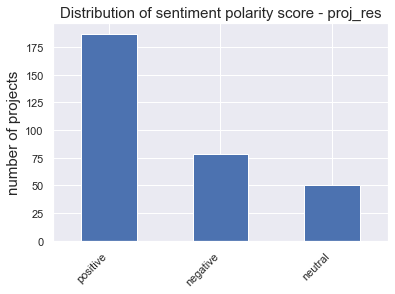

In [76]:
plot = df3['res_polarity_label'].value_counts().plot(kind='bar')
plt.ylabel('number of projects', fontsize = 15)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of sentiment polarity score - proj_res', fontsize = 15)

Text(0.5, 1.0, 'Distribution of sentiment subjectivity score - proj_res')

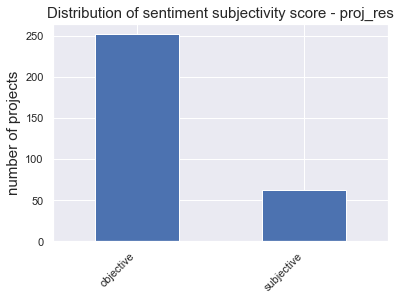

In [77]:
plot = df3['res_subjectivity_label'].value_counts().plot(kind='bar')
plt.ylabel('number of projects', fontsize = 15)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of sentiment subjectivity score - proj_res', fontsize = 15)

Text(0.5, 1.0, 'Distribution of sentiment polarity score - proj_res')

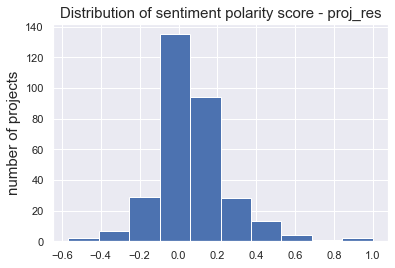

In [78]:
df3['res_polarity'].hist() #distribution of polarity scores
plt.ylabel('number of projects', fontsize = 15)
plt.title('Distribution of sentiment polarity score - proj_res', fontsize = 15)

Text(0.5, 1.0, 'Distribution of sentiment polarity score - proj_res')

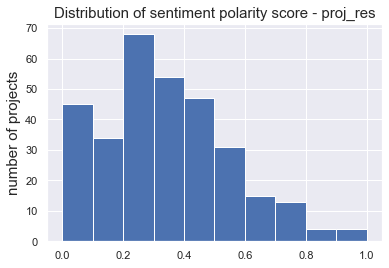

In [79]:
df3['res_subjectivity'].hist() #distribution of subjectivity scores
plt.ylabel('number of projects', fontsize = 15)
plt.title('Distribution of sentiment polarity score - proj_res', fontsize = 15)